<a href="https://colab.research.google.com/github/jfimbett/RM_Lux/blob/main/code_rm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supporting Jupyter notebook

## Risk Management for Financial Institutions - University of Luxembourg

### Juan F. Imbet Ph.D. Paris Dauphine - PSL


Visualizing the Value at Risk

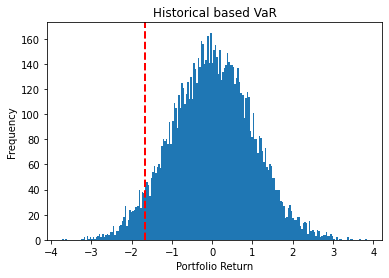

In [1]:
#%%
import numpy as np
from matplotlib import pyplot as plt

# show in a distribution the VaR of a portfolio
def showVaR(portfolio, confidence):
    # calculate the VaR of the portfolio
    VaR = np.percentile(portfolio, confidence)
    # plot the VaR
    plt.hist(portfolio, bins=200)
    plt.axvline(VaR, color='r', linestyle='dashed', linewidth=2)
    # add title and axis names
    plt.title('Historical based VaR')
    plt.xlabel('Portfolio Return')
    plt.ylabel('Frequency')
    plt.show()
    
# example of showVaR
portfolio = np.random.normal(0, 1, 10000)
showVaR(portfolio, 5)
# %%


## Portfolio Allocation Example

Load data

In [6]:
import pandas as pd
from pandas_datareader import data as wb
import requests
from tqdm import tqdm 
# headers 
session = requests.session()
session.headers['User-Agent'] = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'


# load historical prices for the 50 largest US stocks
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 
           'BRK-B', 'JPM', 'JNJ', 'V', 'PG', 
           'MA', 'UNH', 'HD', 'VZ', 'INTC', 
           'DIS', 'CMCSA', 'PFE', 'ADBE', 'KO', 
           'T', 'NFLX', 'PEP', 'NVDA', 'ABT', 
           'PYPL', 'MRK', 'CRM', 'CSCO', 'TMO', 
           'AVGO', 'ORCL', 'COST', 'TSLA', 'ACN', 
           'XOM', 'BAC', 'CVX', 'WFC', 'MCD', 
           'QCOM', 'MDT', 'WMT', 'PM', 'LIN', 
           'UNP', 'UPS', 'LOW', 'BA', 'GME']
data = pd.DataFrame()
for t in tqdm(tickers):
    data[t] = wb.get_data_yahoo(t, '2010-1-1', interval = 'm', session = session)['Adj Close']
    

# calculate the log returns
log_returns = np.log(1 + data.pct_change())
# compute expected returns and covariance
mu = log_returns.mean() 
sigma = log_returns.cov()

mu


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


AAPL     0.020705
MSFT     0.015836
AMZN     0.017364
GOOGL    0.012979
FB      -0.086276
BRK-B    0.009102
JPM      0.010113
JNJ      0.009133
V        0.015733
PG       0.008227
MA       0.017526
UNH      0.019112
HD       0.017730
VZ       0.006042
INTC     0.005220
DIS      0.008663
CMCSA    0.011305
PFE      0.009839
ADBE     0.015118
KO       0.008114
T        0.006255
NFLX     0.022977
PEP      0.009713
NVDA     0.024788
ABT      0.011152
PYPL     0.008512
MRK      0.009909
CRM      0.014155
CSCO     0.007283
TMO      0.016323
AVGO     0.023942
ORCL     0.009368
COST     0.015737
TSLA     0.033251
ACN      0.014324
XOM      0.006617
BAC      0.006674
CVX      0.009197
WFC      0.005239
MCD      0.011823
QCOM     0.009617
MDT      0.005794
WMT      0.008627
PM       0.009150
LIN      0.011305
UNP      0.014279
UPS      0.010081
LOW      0.016204
BA       0.008679
GME      0.013542
dtype: float64

In [8]:
#sigma

Data on common factors, data cleaning and optimization

In [9]:
# convert index from yyy-mm-dd to yyy-mm
data.index = data.index.strftime('%Y-%m')


# %%
# download zip folder in url and load file inside to csv
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'
import requests
import zipfile
import io
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# %%
# read the csv file starting from the 4th row and finishing in the first empty row found
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, nrows=712, index_col=0, parse_dates=True)

# %%
# factors' index is yyymm format, convert it to yyyy-mm
factors.index = factors.index.astype(str).str[:-2] + '-' + factors.index.astype(str).str[-2:]
# rename index to Date
factors.index.name = 'Date'

# convert the date of log_returns to yyyy-mm
log_returns.index = log_returns.index.strftime('%Y-%m')

# merge factors and log_returns on Date
df = pd.merge(factors, log_returns, on='Date')

# import sm
import statsmodels.api as sm
# drop NaN values
df = df.dropna()
# for each ticker, compute the beta with respect to the 5 factors
B = np.zeros((len(tickers), 5))
for i, t in enumerate(tickers):
    # compute the regression
    X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = X/100
    y = df[t]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    # store the betas
    B[i, :] = model.params[1:]
    
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

# sigma and mu to numpy
sigma = sigma.to_numpy()
mu = mu.to_numpy()


# correlation matrix 
C = sigma / np.sqrt(np.diag(sigma)) / np.sqrt(np.diag(sigma)).reshape(-1, 1)


      
        


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:

# for an alpha of 0.05 compute the inverse of the cumulative distribution function of a standard normal
alpha = 0.05
# import norm
from scipy.stats import norm
eta = -norm.ppf(alpha)

# V is eta times the square root of the diagonal of sigma
V = eta * np.sqrt(np.diag(np.diag(sigma)))

N = len(tickers)
# We include all decision variables in a single vector x
# first N elements are the weights of the portfolio
# second N elements are the weights of the long positions
# third N elements are the weights of the short positions
# last element is cash

# objective function and Parameters
gamma = 2
L = 1.5
beta_bar = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
beta_ub = np.array([1.0, 1.0, 1.0, 1.0, 1.0])*0.5
beta_lb = np.array([1.0, 1.0, 1.0, 1.0, 1.0])*0.5
u_b = 0.2 # upper bound for theta
l_b = -0.2 # lower bound for theta
VaR_max = 1.9 # large loss in terms of % of portfolio value
U = lambda x : 1000*(x[:N].T @ mu \
    - 0.5*gamma *x[:N].T @ sigma @ x[:N])

# example, equally weighted portfolio
x_test = np.concatenate((np.ones(N)/N, np.ones(N)/N, np.zeros(N), [0]))
U(x_test)


9.033200980995433

In [13]:
#%% 
constraints = []
# Sum of weights = 1
constraints.append(NonlinearConstraint(\
    lambda x: np.sum(x[:N]) + x[-1], 1, 1))

# theta is expressed as the long minus the short position

constraints.append(NonlinearConstraint(\
    lambda x: x[:N] - (x[N:2*N]- x[2*N:3*N]), 0, 0))

# the long and short positions are non-negative

constraints.append(NonlinearConstraint(\
    lambda x: x[N:2*N], 0, np.inf))
    

constraints.append(NonlinearConstraint(\
    lambda x: x[2*N:3*N], 0, np.inf))

# positive cash

constraints.append(NonlinearConstraint(\
    lambda x: x[-1], 0, np.inf))

constraints.append(NonlinearConstraint(\
        lambda x: x[:N], l_b*np.ones(N), u_b*np.ones(N)))

# leverage constraint
constraints.append(NonlinearConstraint(\
    lambda x: np.sum(x[N:2*N]) + np.sum(x[2*N:3*N]), 0, L))

# Factor exposure constraint
constraints.append(NonlinearConstraint(\
    lambda x: B.T @ x[:N], beta_bar-beta_lb, beta_bar+beta_ub))

# VaR constraint
constraints.append(NonlinearConstraint(\
    lambda x: np.sqrt(x[:N].T @ V @ C @ V @ x[:N]), 0, VaR_max))

solution = minimize(
    # objective function
    lambda x : -U(x), 
    # initial value
    #x0 = np.concatenate((np.ones(N)/N, np.ones(N)/N, np.zeros(N), [0])),
    x0 = np.zeros(3*N+1),
    # constraints
    constraints = constraints)

if solution.success:
  # print the results of the optimization nicely
  x = solution.x
  print('Optimal weights')
  print("----------------")
  print("Long positions")
  for i, t in enumerate(tickers):
      if x[N+i] > 1e-5:
          # print the ticker and the weight rounding decimals
          print(t, round(x[N+i], 3))

  print("----------------")
  print("Short positions")
  for i, t in enumerate(tickers):
      if x[2*N+i] > 1e-5:
          # print the ticker and the weight rounding decimals
          print(t, round(x[2*N+i], 3))
  print("----------------")
  print("Cash", round(x[-1], 3))
  print("----------------")
  # what is the exposure to the factors?
  print("Exposure to the factors")
  print("-----------------------")
  exp = B.T @ x[:N]
  print("Mkt-RF", round(exp[0], 3))
  print("SMB", round(exp[1], 3))
  print("HML", round(exp[2], 3))
  print("RMW", round(exp[3], 3))
  print("CMA", round(exp[4], 3))

  # compute the VaR of the portfolio
  VaR = np.sqrt(x[:N].T @ V @ C @ V @ x[:N])
  # print results
  print("VaR", round(VaR, 3)) 
else:
  print("Optimal Solution Not Found")


Optimal weights
----------------
Long positions
AAPL 0.085
MA 0.019
UNH 0.2
HD 0.2
TSLA 0.112
PM 0.2
LOW 0.2
----------------
Short positions
FB 0.2
INTC 0.17
NVDA 0.031
PYPL 0.023
BA 0.023
GME 0.037
----------------
Cash 0.467
----------------
Exposure to the factors
-----------------------
Mkt-RF 0.5
SMB -0.5
HML -0.5
RMW 0.396
CMA 0.082
VaR 0.101


# MIP Formulation

- Assume that now we require to have at least $n_s$ short stocks, we will see how we can obtain the optimal solution using a free version of the comercial solver Gurobi


In [14]:
!pip install -i https://pypi.gurobi.com gurobipy

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.5 MB/s 


In [15]:
import gurobipy as gp
from gurobipy import GRB

# the free license has a limit on variables, we will use only 10 stocks, and require minimum 2 short stocks, we will also remove the factor constraint as it is the "hardest"
# we will use the first 30 stocks

N = 30
ns = 2

M = 1E9
try:
    indices = range(N)
    tick_names = tickers[:N]
    # Create a new model
    model = gp.Model("Risk Management")

    model.params.NonConvex = 2

    # Create variables
    x     = model.addVars(indices, vtype=GRB.BINARY, name="x")
    x_pos = model.addVars(indices, vtype=GRB.BINARY, name="x_pos")
    x_neg = model.addVars(indices, vtype=GRB.BINARY, name="x_neg")

    theta      = model.addVars(indices, lb = l_b, ub = u_b)
    theta_pos  = model.addVars(indices, lb = 0,   ub = u_b)
    theta_neg  = model.addVars(indices, lb = 0,   ub = -l_b)

    theta_cash = model.addVar(lb = 0,   ub = float('inf'), name = "cash")

    # Budget constraint
    model.addConstr(theta.sum()+theta_cash == 1.0)

    # Long-Short definitions
    for i in range(N):
        model.addConstr(theta[i]                    == theta_pos[i] - theta_neg[i])
        model.addConstr(x[i]                        == x_pos[i]     + x_neg[i])
        model.addConstr(M*theta_pos[i]              >= x_pos[i])
        model.addConstr(theta_pos[i]                <= M*x_pos[i])
        model.addConstr(M*theta_neg[i]              >= x_neg[i])
        model.addConstr(theta_neg[i]                <= M*x_neg[i])

    #Leverage
    model.addConstr(theta_pos.sum() + theta_neg.sum() <= L)

    # VaR 
    V_C_V = V @ C @ V

    #model.addConstr(gp.quicksum(theta[i]*V_C_V[i,j]*theta[j] for i in range(N) for j in range(N)) <= VaR_max**2)

    # minimum 5 short sales

    model.addConstr(gp.quicksum(x_neg[i] for i in range(N))>=ns)

    # Set objective
    model.setObjective(gp.quicksum(theta[i]*mu[i] for i in range(N)) - 0.5*gamma*gp.quicksum(theta[i]*sigma[i,j]*theta[j] for i in range(N) for j in range(N)), GRB.MAXIMIZE)

    # Optimize model
    model.optimize()

    vars = model.getVars()

    vars = vars[3*N:4*N] # first 3*N vars are the binary ones

    for (name, var) in zip(tick_names, vars):
      print(f"Ticker: {name} - Position: {round(var.X*100,2)} %")
    
    #for v in model.getVars():
    #    print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % model.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Restricted license - for non-production use only - expires 2024-10-28
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 183 rows, 181 columns and 541 nonzeros
Model fingerprint: 0x3c90a43e
Model has 465 quadratic objective terms
Variable types: 91 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [5e-03, 9e-02]
  QObjective range [2e-04, 1e-01]
  Bounds range     [2e-01, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0062918
Presolve removed 30 rows and 61 columns
Presolve time: 0.05s
Presolved: 1024 rows, 586 columns, 3556 nonzeros
Presolved model has 30 quadratic constr

Help on method optimize in module gurobipy:

optimize(callback=None) method of gurobipy.Model instance
    ROUTINE:
      optimize()
    
    PURPOSE:
      Optimize the model.
    
    ARGUMENTS:
      callback (function, optional): Callback function which takes two
               arguments, model and where.
    
    RETURN VALUE:
      None.
    
    EXAMPLE:
      model.optimize()
    
    NOTES:
      The algorithm used to optimize the model depends on the model type and
      on the parameter settings.  A MIP model will always be optimized using
      the branch-and-cut algorithm.  A continuous model will be optimized
      using the dual simplex algorithm by default; the Method parameter
      can be used to choose a different algorithm.

